In [28]:
###########################   R script  ###########################

In [1]:
library(CellChat)
library(RColorBrewer)
library(Seurat)
library(nichenetr)
library(tidyverse)
library(dplyr)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Attaching SeuratObject

Attaching sp

Registered S3 methods overwritten by 'proxy':
  method               from    
  print.registry_field registry
  print.registry_entry registry

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.7     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── ti

In [32]:
TCELL_DATA_PATH = 'project_path/Tcell/gene/BBKNN/sizeFactor_sctransform.rds'
MACROPHAGE_DATA_PATH = 'project_path/Myloid/macrophage_sctransform.rds'

## The number of interactions
* CellChat

In [ ]:
PRE_CR_CELLCHAT_OBJECT_PATH = 'project_path/cellchat/sizeFactor_preCR_allCell.rds'
PRE_NCR_CELLCHAT_OBJECT_PATH = 'project_path/cellchat/sizeFactor_preNCR_allCell.rds'
ALLSUBS_CELLCHAT_OBJECT_PATH = 'project_path/cellchat/allCell.rds'

### Figure 5D

In [19]:
pre_NC = readRDS(PRE_CR_CELLCHAT_OBJECT_PATH)
pre_NCR = readRDS(PRE_NCR_CELLCHAT_OBJECT_PATH)

object.list = list(pre_CR = pre_NC, pre_NCR = pre_NCR)
cellchat = mergeCellChat(object.list, add.names = names(object.list))

Merge the following slots: 'data.signaling','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



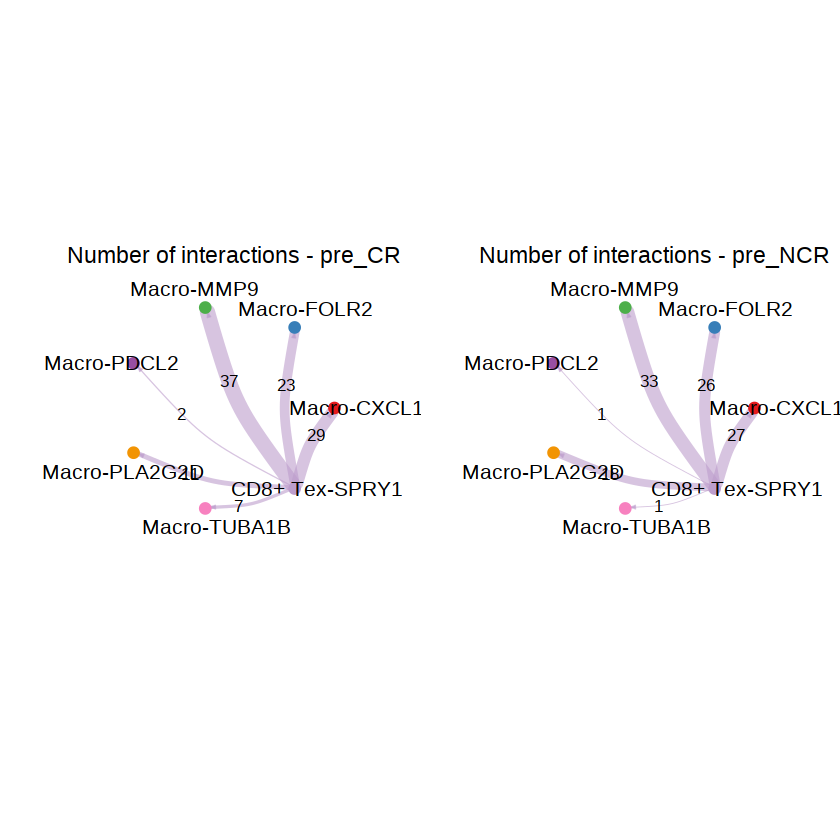

In [22]:
cells = c('Macro-CXCL1','Macro-FOLR2','Macro-MMP9','Macro-PDCL2','Macro-PLA2G2D','Macro-TUBA1B','CD8+ Tex-SPRY1')
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
    count = object.list[[i]]@net$count
    aa = rownames(count)
    aa[which(aa == 'Macro-DEFA3')] = 'Macro-CXCL1'
    rownames(count) = aa
    colnames(count) = aa
    netVisual_circle(count[cells,cells], weight.scale = T, label.edge= T, edge.weight.max = 50, 
                   sources.us = 'CD8+ Tex-SPRY1',
                   targets.use = c('Macro-CXCL1','Macro-FOLR2','Macro-MMP9','Macro-PDCL2','Macro-PLA2G2D','Macro-TUBA1B'),
                   edge.width.max = 12, title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

### Figure 5F

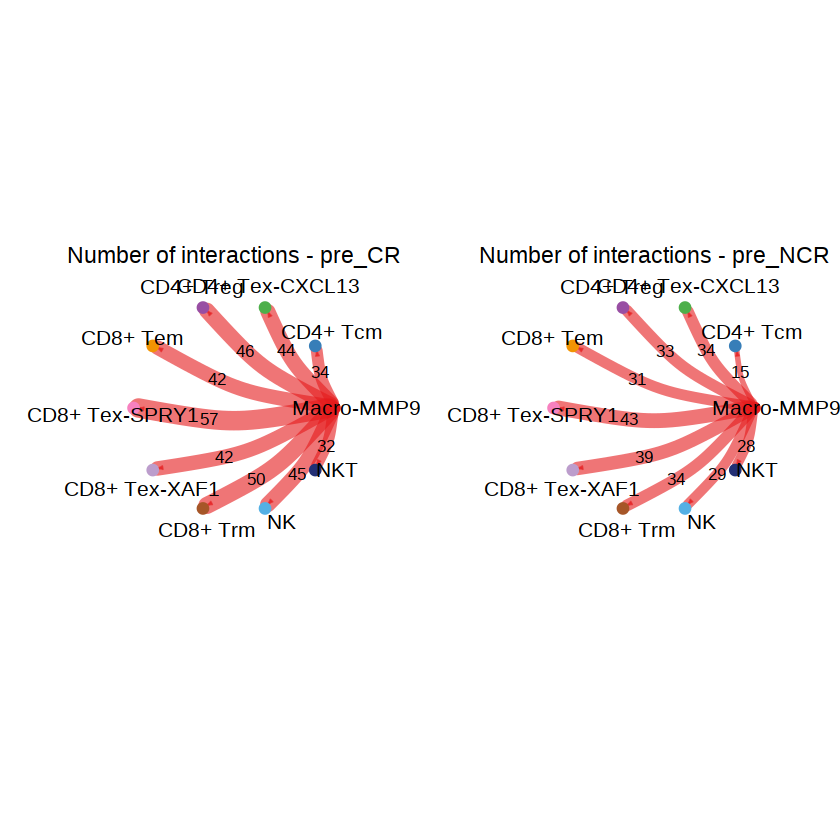

In [23]:
cells = c('Macro-MMP9','CD4+ Tcm','CD4+ Tex-CXCL13','CD4+ Treg','CD8+ Tem','CD8+ Tex-SPRY1','CD8+ Tex-XAF1','CD8+ Trm','NK','NKT')
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
    netVisual_circle(object.list[[i]]@net$count[cells,cells], weight.scale = T, label.edge= T, edge.weight.max = 60, 
                   sources.us = 'Macro-MMP9',
                   targets.use = cells[2:length(cells)],
                   edge.width.max = 12, title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

### Figure 6F

In [25]:
cellchat = readRDS(ALLSUBS_CELLCHAT_OBJECT_PATH)

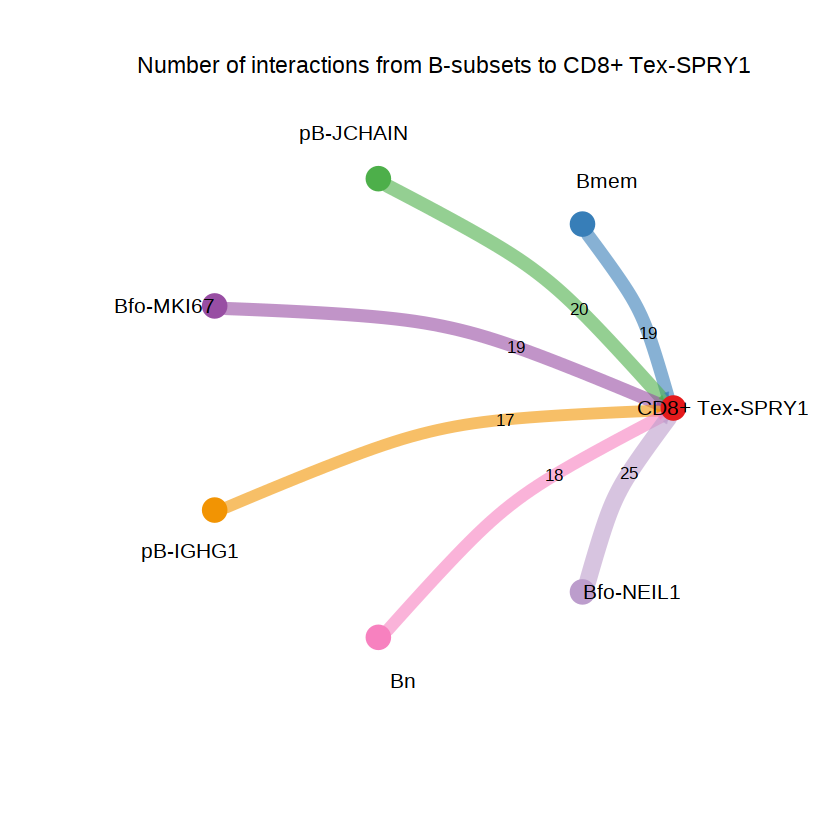

In [27]:
cells = c('CD8+ Tex-SPRY1','Bmem','pB-JCHAIN','Bfo-MKI67','pB-IGHG1','Bn','Bfo-NEIL1')
p = netVisual_circle(cellchat@net$count[cells,cells], weight.scale = T, label.edge= T,  edge.weight.max = 30, 
                   sources.us = cells[2:7],
                   targets.use = 'CD8+ Tex-SPRY1',
                   edge.width.max = 12, title.name = paste0("Number of interactions from B-subsets to CD8+ Tex-SPRY1"))

## Prioritized ligands
* NicheNet
* Matrixes of ligand_target_matrix, lr_network and weighted_networks are download from https://github.com/saeyslab/nichenetr 

In [13]:
nicheFun = function(background_expressed_genes,
                                expressed_genes_sender,
                                expressed_genes_receiver,
                                geneset_oi,
                                ligand_target_matrix,
                                lr_network, 
                                weighted_networks,
                                weighted_networks_lr,
                               dotplot_object
   ){
    ## potatial ligand
    ligands = unique(lr_network$from)
    receptors = unique(lr_network$to)

    expressed_ligands = intersect(ligands,expressed_genes_sender)
    expressed_receptors = intersect(receptors,expressed_genes_receiver)

    potential_ligands = lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors) %>% pull(from) %>% unique()

    ## ligand activity
    ligand_activities = predict_ligand_activities(
                                              geneset = geneset_oi, 
                                              background_expressed_genes = background_expressed_genes, 
                                              ligand_target_matrix = ligand_target_matrix, 
                                              potential_ligands = potential_ligands)

    ligand_activities = ligand_activities %>% arrange(-pearson) %>% mutate(rank = rank(desc(pearson)))

    ## ligand-target heatmap
    best_upstream_ligands = ligand_activities %>% top_n(20, pearson) %>% arrange(-pearson) %>% pull(test_ligand) %>% unique()
    active_ligand_target_links_df = best_upstream_ligands %>% lapply(
                                                                 get_weighted_ligand_target_links,
                                                                 geneset = geneset_oi, 
                                                                 ligand_target_matrix = ligand_target_matrix, 
                                                                 n = 200) %>% bind_rows() %>% drop_na()

     active_ligand_target_links = prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, 
                                                                 ligand_target_matrix = ligand_target_matrix, 
                                                                 cutoff = 0.33)

    order_ligands = intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev() %>% make.names()
    order_targets = active_ligand_target_links_df$target %>% unique() %>% intersect(rownames(active_ligand_target_links)) %>% make.names()
    rownames(active_ligand_target_links) = rownames(active_ligand_target_links) %>% make.names() # make.names() for heatmap visualization of genes like H2-T23
    colnames(active_ligand_target_links) = colnames(active_ligand_target_links) %>% make.names() # make.names() for heatmap visualization of genes like H2-T23

    vis_ligand_target = active_ligand_target_links[order_targets,order_ligands] %>% t()
    p_ligand_target_network = vis_ligand_target %>% make_heatmap_ggplot("Prioritized ligands","Predicted target genes", 
                                                                    color = "purple",legend_position = "top", x_axis_position = "top",
                                                                    legend_title = "Regulatory potential")  + theme(axis.text.x = element_text(face = "italic")) + 
    scale_fill_gradient2(low = "whitesmoke",  high = "purple")

    ## top ligands
    ligand_pearson_matrix = ligand_activities %>% select(pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand)

    rownames(ligand_pearson_matrix) = rownames(ligand_pearson_matrix) %>% make.names()
    colnames(ligand_pearson_matrix) = colnames(ligand_pearson_matrix) %>% make.names()
    vis_ligand_pearson = ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson")
    p_ligand_pearson = vis_ligand_pearson %>% make_heatmap_ggplot("Prioritized ligands","Ligand activity", color = "darkorange",legend_position = "top", x_axis_position = "top", 
                                                              legend_title = "Pearson correlation coefficient\ntarget gene prediction ability)") + 
    theme(legend.text = element_text(size = 9))

    ## ligand-receptor heatmap
    lr_network_top = lr_network %>% filter(from %in% best_upstream_ligands & to %in% expressed_receptors) %>% distinct(from,to)
    best_upstream_receptors = lr_network_top %>% pull(to) %>% unique()

    lr_network_top_df_large = weighted_networks_lr %>% filter(from %in% best_upstream_ligands & to %in% best_upstream_receptors)

    lr_network_top_df = lr_network_top_df_large %>% spread("from","weight",fill = 0)
    lr_network_top_matrix = lr_network_top_df %>% select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df$to)

    dist_receptors = dist(lr_network_top_matrix, method = "binary")
    hclust_receptors = hclust(dist_receptors, method = "ward.D2")
    order_receptors = hclust_receptors$labels[hclust_receptors$order]
    
    dist_ligands = dist(lr_network_top_matrix %>% t(), method = "binary")
    hclust_ligands = hclust(dist_ligands, method = "ward.D2")
    order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order]

    order_receptors = order_receptors %>% intersect(rownames(lr_network_top_matrix))
    order_ligands_receptor = order_ligands_receptor %>% intersect(colnames(lr_network_top_matrix))

    vis_ligand_receptor_network = lr_network_top_matrix[order_receptors, order_ligands_receptor]
    rownames(vis_ligand_receptor_network) = order_receptors %>% make.names()
    colnames(vis_ligand_receptor_network) = order_ligands_receptor %>% make.names()
    vis_ligand_receptor_network = as.matrix(data.frame(vis_ligand_receptor_network)[,intersect(rownames(vis_ligand_pearson),colnames(vis_ligand_receptor_network))])

    p_ligand_receptor_network = vis_ligand_receptor_network %>% t() %>% make_heatmap_ggplot("Ligands","Receptors", color = "mediumvioletred", x_axis_position = "top",legend_title = "Prior interaction potential")

    ## dotplot of ligands
    rotated_dotplot = DotPlot(dotplot_object, 
        features = gsub('\\.','-',rownames(vis_ligand_pearson)))+RotatedAxis()+coord_flip()
    
    ## combined plot
    row1 = cowplot::plot_grid(
    p_ligand_pearson + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()),
    rotated_dotplot + theme(legend.position = "none", 
                            axis.ticks = element_blank(), 
                            axis.title.x = element_text(size = 12), 
                            axis.text.y = element_text(face = "italic", size = 9),
                            axis.text.x = element_text(size = 9,  angle = 45,hjust = 0)) + 
    ylab("Expression in Sender") + xlab("") + scale_y_discrete(position = "right"),
    p_ligand_receptor_network+ theme(legend.position = "none"),
      #align = "hv",
      ncol = 3,
      rel_widths = c(ncol(vis_ligand_pearson)+8, 12,  nrow(vis_ligand_receptor_network)-5))

    legends = cowplot::plot_grid(
                    ggpubr::as_ggplot(ggpubr::get_legend(rotated_dotplot)),
                    cowplot::plot_grid(ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_pearson)),
                                                       ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_receptor_network)),
                                                       ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_target_network)),
                                                       ncol = 1),
                    nrow=1,
                    align = "hv")

    row2 = cowplot::plot_grid(
                          p_ligand_target_network + theme(legend.position = "none") + ylab(""),
                          legends,
                          nrow=1,
                          rel_widths = c(ncol(vis_ligand_target),12))
    combined_plot = cowplot::plot_grid(row1, row2,rel_heights = c(14,12), nrow = 2, align = "hv")

    return(list(row1 = row1,row2 = row2, combined = combined_plot))
       }

### Figure 5C
* ligand cell type: CD8+ Tex-SPRY1
* target cell type: macrophages
* differential expression genes: Pre-CR vs Pre-NCR

In [3]:
setwd('/share/pub/zhangyr/projects/cooperation/SJTU/ESCC')

In [8]:
ligand_target_matrix = readRDS('project_path/ligand_target/ligand_target_matrix.rds')
lr_network = readRDS('project_path/ligand_target/lr_network.rds')
weighted_networks = readRDS('project_path/data/ligand_target/weighted_networks.rds')

weighted_networks_lr = weighted_networks$lr_sig %>% inner_join(lr_network %>% distinct(from,to), by = c("from","to"))

In [4]:
tcell = readRDS(TCELL_DATA_PATH)
tcell = tcell[,which(tcell$treat == 'Pre')]
DefaultAssay(tcell) = 'SCT'
list_expressed_genes_sender = get_expressed_genes('CD8+ Tex-SPRY1', tcell, pct = 0.10)
expressed_genes_sender = list_expressed_genes_sender %>% unlist() %>% unique()

Warning message in get_expressed_genes("CD8+ Tex-SPRY1", tcell, pct = 0.1):
“Seurat object is result from the Seurat single-cell transform workflow. The expressed genes are defined based on the SCT slot. You can change this via the assay_oi parameter of the get_expressed_genes() functions. Recommended assays: RNA or SCT”


In [9]:
macro = readRDS('./results/step2_subClustering/Myeloid/Macrophages_sizefactor.rds')
macro = macro[,which(macro$treat == 'Pre')]
DefaultAssay(macro) = 'SCT'
Idents(macro) = macro$treat
expressed_genes_receiver = get_expressed_genes('Pre', macro, pct = 0.10)
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]

Warning message in get_expressed_genes("Pre", macro, pct = 0.1):
“Seurat object is result from the Seurat single-cell transform workflow. The expressed genes are defined based on the SCT slot. You can change this via the assay_oi parameter of the get_expressed_genes() functions. Recommended assays: RNA or SCT”


In [10]:
## receiver: geneset_oi
markers = read.table('./results//publication//suppTables//nichenet_figure4f.csv',sep='\t',header=T)
geneset_oi = markers %>% filter(p_val_adj <= 0.05 & avg_log2FC >= 0.5) %>% pull(gene)
geneset_oi = geneset_oi %>% .[. %in% rownames(ligand_target_matrix)]

In [11]:
Idents(tcell)=tcell$leiden_name_0418

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Scaling data with a low number of groups may produce misleading results”


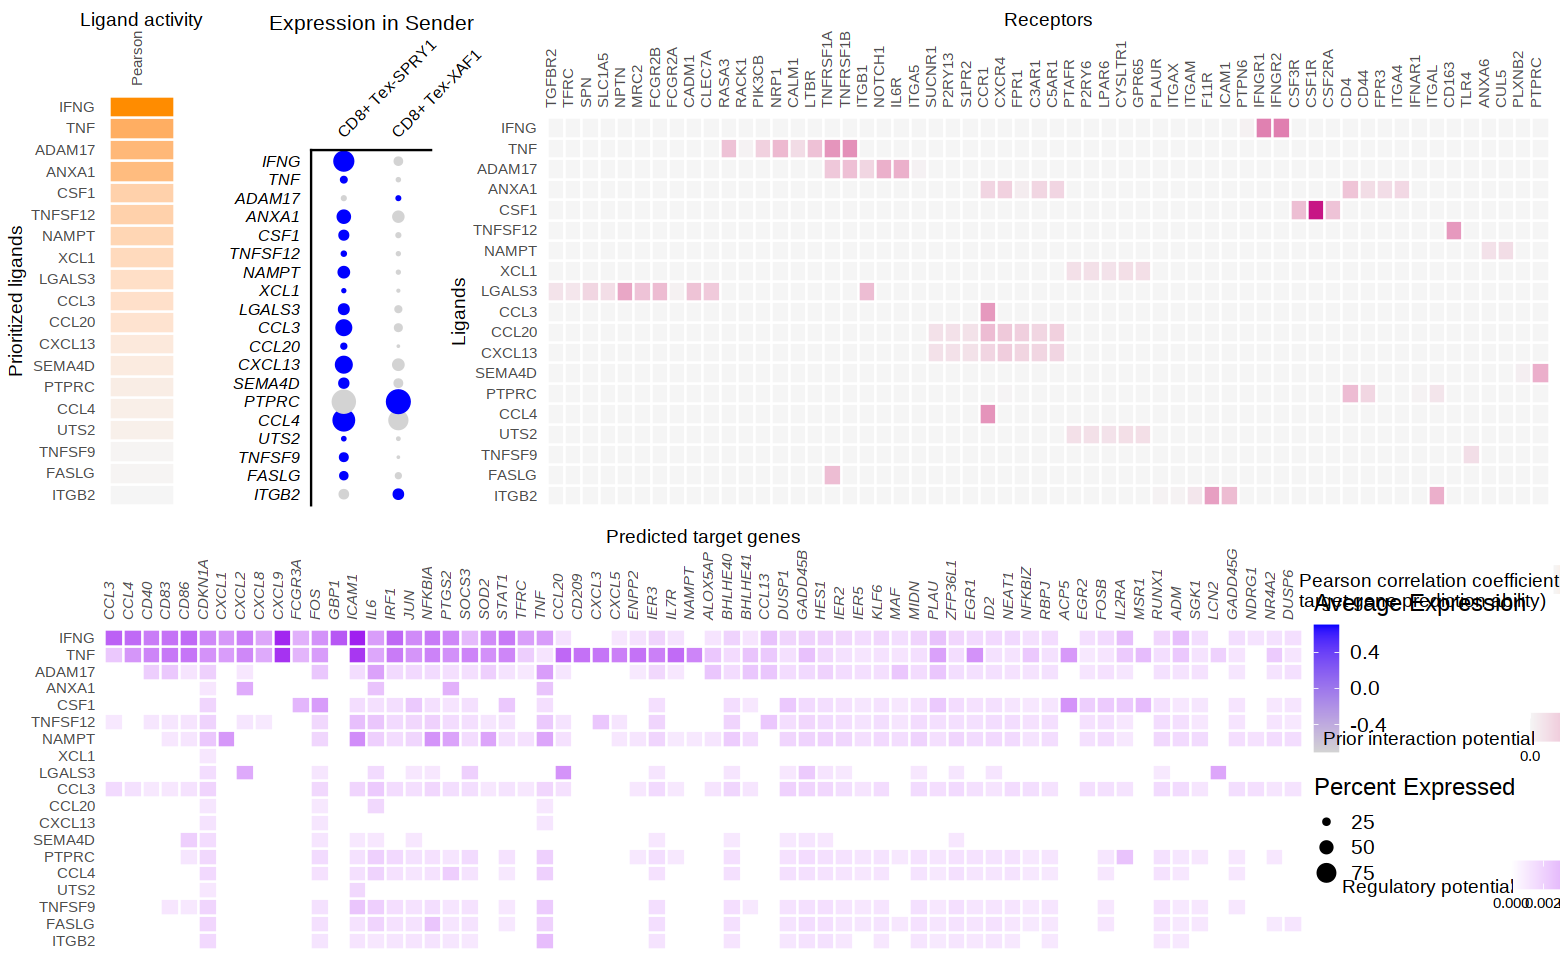

In [17]:
res = nicheFun(background_expressed_genes,
                                expressed_genes_sender,
                                expressed_genes_receiver,
                                geneset_oi,
                                ligand_target_matrix,
                                lr_network, 
                                weighted_networks,
                                weighted_networks_lr,
            tcell[,which(tcell$leiden_name_0418 %in% c('CD8+ Tex-SPRY1','CD8+ Tex-XAF1'))])
options(repr.plot.width=13, repr.plot.height=8)
res$combined

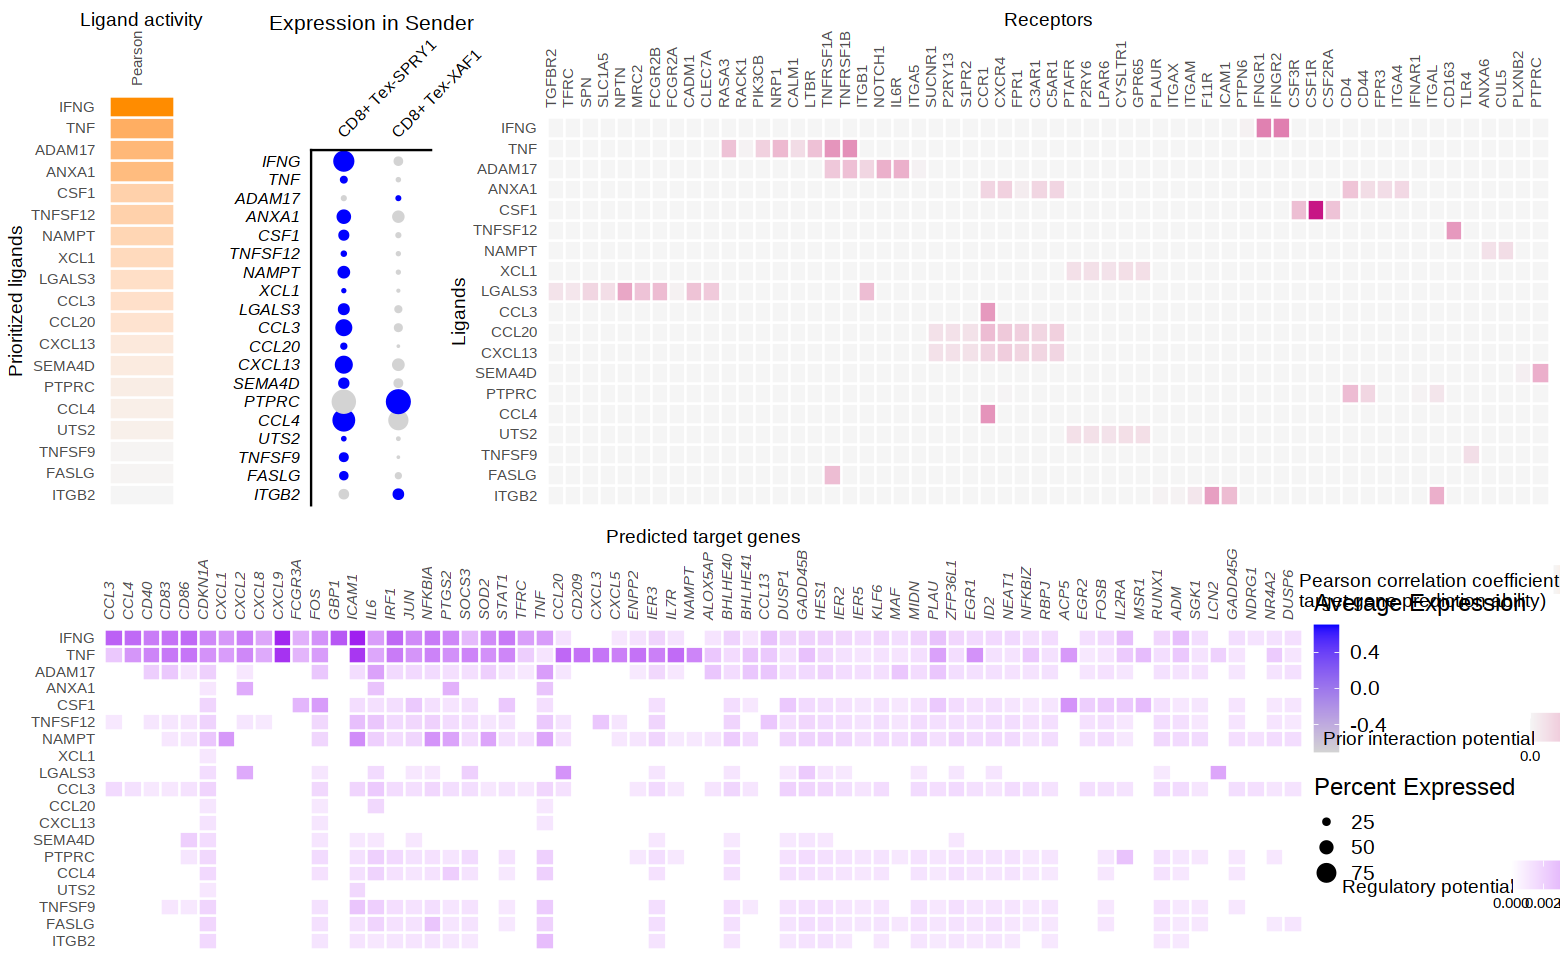

### Figure 5G
* ligand cell type: Pre_CR Macro-MMP9
* target cell type: CD8+ T cells
* differential expression genes: Tex-SPRY1 vs other CD8 T cells (Pre-treatment)

In [18]:
## sender
macro = readRDS(MACROPHAGE_DATA_PATH)
Idents(macro) = macro$leiden_name
DefaultAssay(macro) = 'SCT'
list_expressed_genes_sender = get_expressed_genes('Macrophages', macro, pct = 0.10)
expressed_genes_sender = list_expressed_genes_sender %>% unlist() %>% unique()

Warning message in get_expressed_genes("Macrophages", macro, pct = 0.1):
“Seurat object is result from the Seurat single-cell transform workflow. The expressed genes are defined based on the SCT slot. You can change this via the assay_oi parameter of the get_expressed_genes() functions. Recommended assays: RNA or SCT”


In [21]:
macro$treat_celltype = paste(macro$treat,macro$celltype)
macro$treatGroup_celltype = paste(macro$treat_group,macro$celltype)
Idents(macro) = macro$treatGroup_celltype
list_expressed_genes_sender = get_expressed_genes('Pre_CR Macro-MMP9', macro, pct = 0.1)
list_expressed_genes_sender = c(list_expressed_genes_sender,get_expressed_genes('Pre_NCR Macro-MMP9', macro, pct = 0.1))
expressed_genes_sender = list_expressed_genes_sender %>% unlist() %>% unique()

Warning message in get_expressed_genes("Pre_CR Macro-MMP9", macro, pct = 0.1):
“Seurat object is result from the Seurat single-cell transform workflow. The expressed genes are defined based on the SCT slot. You can change this via the assay_oi parameter of the get_expressed_genes() functions. Recommended assays: RNA or SCT”
Warning message in get_expressed_genes("Pre_NCR Macro-MMP9", macro, pct = 0.1):
“Seurat object is result from the Seurat single-cell transform workflow. The expressed genes are defined based on the SCT slot. You can change this via the assay_oi parameter of the get_expressed_genes() functions. Recommended assays: RNA or SCT”


In [26]:
## receiver
tcell = readRDS(TCELL_DATA_PATH)
tcell$treat_celltype = paste(tcell$treat,tcell$leiden_name_0418,sep = '_')
Idents(tcell) = tcell$treat_celltype

DefaultAssay(tcell) = 'SCT'
expressed_genes_receiver = get_expressed_genes(c('Pre_CD8+ Tex-SPRY1','Pre_CD8+ Trm','Pre_CD8+ Tex-XAF1','Pre_CD8+ Tem','Pre_NKT'), tcell, pct = 0.10)
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]

Warning message in get_expressed_genes(c("Pre_CD8+ Tex-SPRY1", "Pre_CD8+ Trm", "Pre_CD8+ Tex-XAF1", :
“Seurat object is result from the Seurat single-cell transform workflow. The expressed genes are defined based on the SCT slot. You can change this via the assay_oi parameter of the get_expressed_genes() functions. Recommended assays: RNA or SCT”


In [29]:
markers = FindMarkers(tcell,
                      ident.1 = colnames(tcell)[which(tcell$treat_cellType == 'Pre_CD8+ Tex-SPRY1')],
                      ident.2 = colnames(tcell)[which(tcell$treat_cellType %in% c('Pre_CD8+ Tem','Pre_CD8+ Trm',
                                                                                  'Pre_CD8+ Tex-XAF1','Pre_NKT'))],
                      only.pos=T,
                      assays = 'SCT'
                     )
markers$gene = rownames(markers)
geneset_oi = markers %>% filter(p_val_adj <= 0.05 & avg_log2FC >= 0.25) %>% pull(gene)
geneset_oi = geneset_oi %>% .[. %in% rownames(ligand_target_matrix)]

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Scaling data with a low number of groups may produce misleading results”


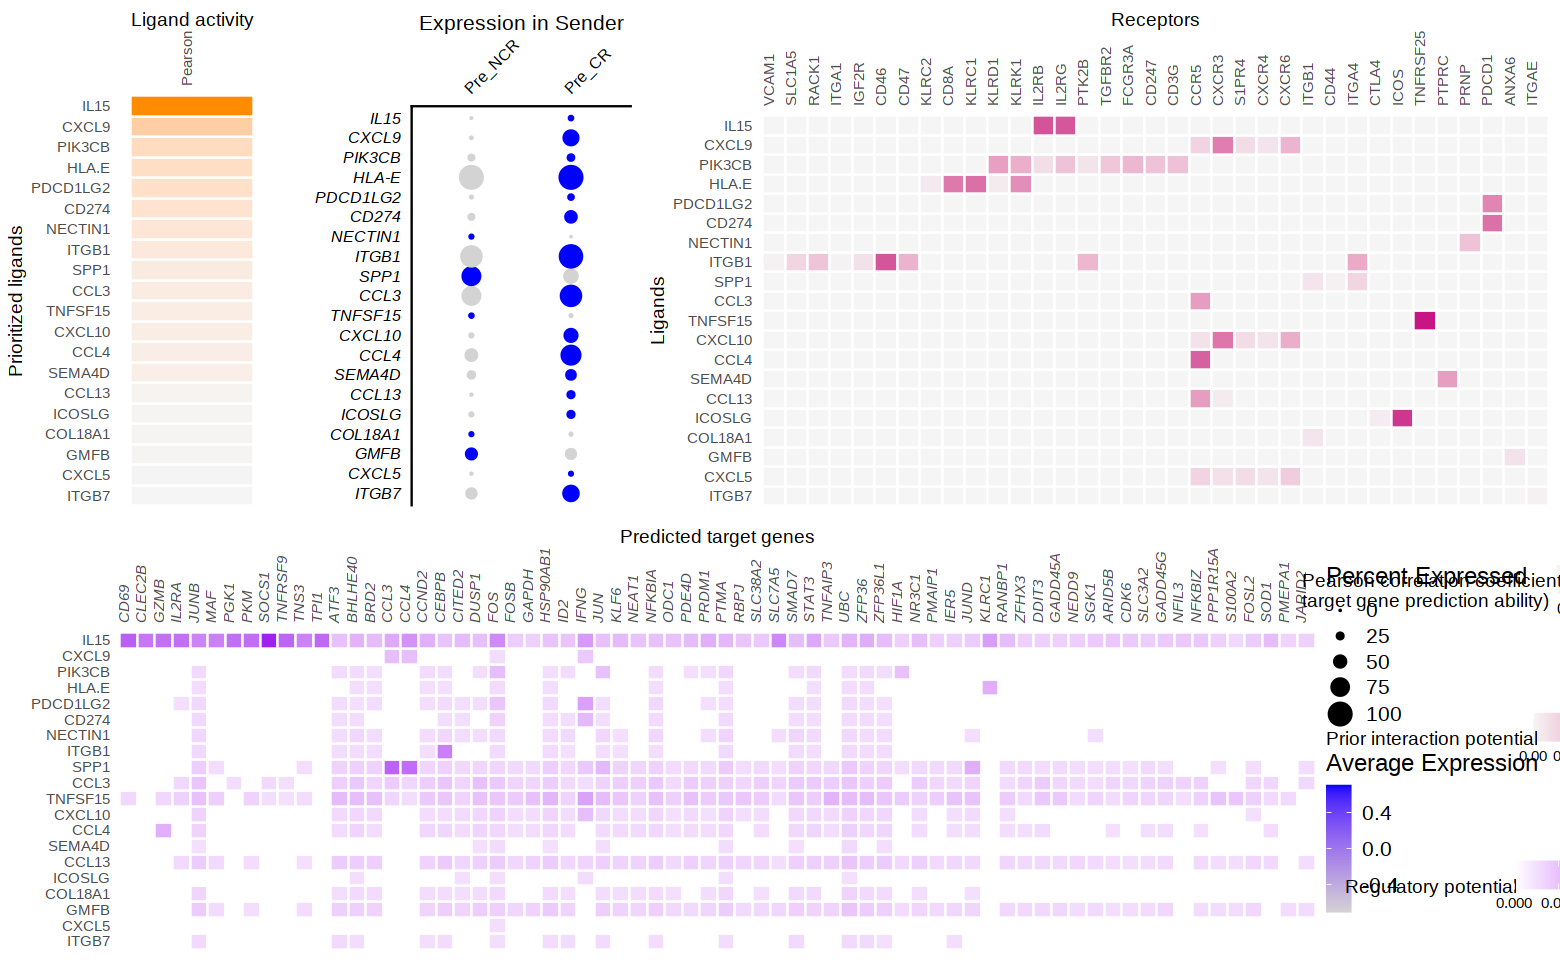

In [30]:
Idents(macro) = macro$treat_group
res = nitFun(background_expressed_genes,
                                expressed_genes_sender,
                                expressed_genes_receiver,
                                geneset_oi,
                                ligand_target_matrix,
                                lr_network, 
                                weighted_networks,
                                weighted_networks_lr,
                                macro[,which(macro$celltype == 'Macro-MMP9' & macro$treat == 'Pre')]
            )
res$combined